In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


K-Means Initiation (by Stefanie)
---------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# Just for inspecting (and not forgetting about potentially useful information from) the whole joined dataset
df_jointdata = pd.read_csv('joint_data.csv')
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [3]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


Cleaning out the noise
--------------------------------------------------------------------------------------------------------------------------------------

K-Means is noise sensitive. If we'd keep very distinct elements, it would return clusters with one (or very few) elements. In our data, we'll define routes as noise, when they pass along less than a certain number of points of interest.

In [4]:
# filtering out any route that passen by less than 10 points of interest
df_poicount = df_poicount.loc[lambda x: x['poi'] > 10]

In [5]:
# Writing the easier to work with and noise strapped df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [6]:
# Calculating the percentage of the feature "tree", thus reminding us of what's special about our dataset
print('Trees make out by far the largest amount in our data.', df_poicount['tree'].sum()/df_poicount.iloc[:, 3:].sum().sum()*100, "% of our points of interest is trees.")

Trees make out by far the largest amount in our data. 80.14321336363837 % of our points of interest is trees.


In [7]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

<AxesSubplot:>

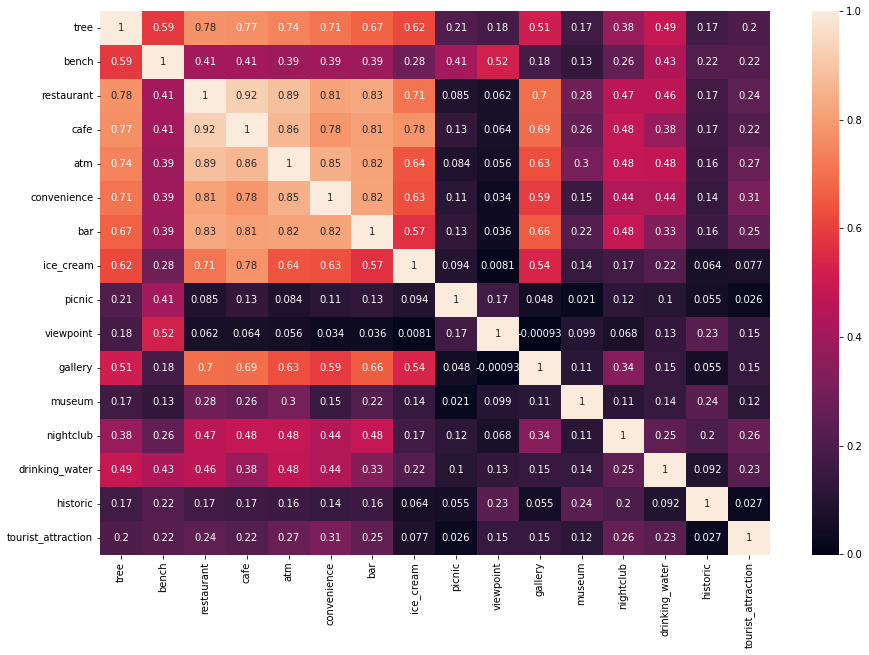

In [8]:
# Getting correlations for all the points of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlations,annot=True)

Over the thumb summary: 

We can see that restaurants, cafes, convenience shops, atms, bars, ice cream shops, galleries, and trees often come along (meaning being on the same route) with each other. It can be suspected that these togeter will form a cluster. (Sometimes, there's also nightclubs and drinking water on these routes.)

Viewpoints and picnic tables don't correlate with most of the other features, not even with each other, which is surprising. But sometimes they come along with benches, which make sense. 

Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. 

Tourist attractions and historic sides don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). 

Nightclubs seem to go best with bars, cafes and atms, but no clear correlation here.

Elbow method for finding the optimal
-----

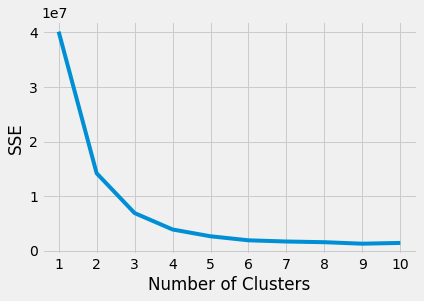

In [9]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)

# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters can be found.

In [10]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

There seems to be 3 clusters.

Silhouette method for finding the optimal k
----------------------

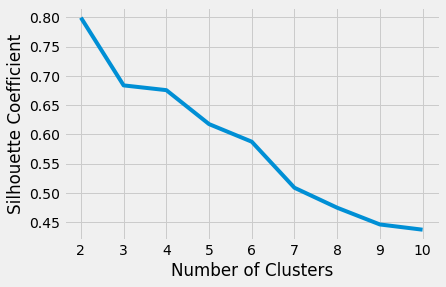

In [11]:
# Making a List for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This would speak for there being 2 clusters. By experimenting a bit with the data (not shown here) we found out, that when we'd reduce it to two clusters, then the biggest cluster would "eat" the second biggest cluster, which is a gross loss in information, especially since the biggest cluster is the biggest by far. So, we'll percede with 3 clusters.

Implementing KMeans
------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=3, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poicount)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [16]:
# Looking at the lowest SSE value
kmeans.inertia_

6890497.935023984

That high number is to be expected, because we have only 430 samples lost in 16 dimensions.

In [17]:
# Looking at the locations of the centroids
kmeans.cluster_centers_

array([[7.12931727e+01, 1.90522088e+01, 4.43373494e+00, 2.41767068e+00,
        9.31726908e-01, 5.78313253e-01, 7.59036145e-01, 2.73092369e-01,
        4.21686747e-01, 2.77108434e-01, 2.08835341e-01, 2.48995984e-01,
        1.64658635e-01, 1.16465863e-01, 9.63855422e-02, 7.63052209e-02],
       [1.40500000e+03, 1.14705882e+02, 4.71176471e+01, 2.90588235e+01,
        1.28235294e+01, 9.47058824e+00, 8.88235294e+00, 2.94117647e+00,
        1.64705882e+00, 1.17647059e+00, 2.35294118e+00, 1.00000000e+00,
        1.76470588e+00, 1.58823529e+00, 4.11764706e-01, 3.52941176e-01],
       [4.49275362e+02, 5.49855072e+01, 1.55652174e+01, 8.88405797e+00,
        3.50724638e+00, 3.43478261e+00, 2.89855072e+00, 1.33333333e+00,
        6.23188406e-01, 6.66666667e-01, 6.23188406e-01, 5.36231884e-01,
        5.07246377e-01, 4.05797101e-01, 2.17391304e-01, 2.02898551e-01]])

Looks like distinct centroids, however when I ran this bevore, there were two quite similar ones (at eyesight quite close to each other) which lead me to believe that it might be only two "real" clusters.

In [18]:
# Number of iterations required to converge
print(kmeans.n_iter_, 'iterations')

7 iterations


That's surprisingsly fast (however before, I had had only 2 even). I haven't come to grips yet what this would tell us about the data.

In [19]:
# Cluster assignments
kmeans.labels_[:20] #looking at the first 20

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Probably all green routes with restaurats, cafes and so on (let's call it the "green city route") ... I'm sure that cluster is by far the largest.

In [20]:
# Checking how many times each lable appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 249, 1: 17, 2: 69}

There is one cluster that is much bigger than the others. It's probably the "green city route".

In [21]:
# Assigning the three cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,71.293173,19.052209,4.433735,2.417671,0.931727,0.578313,0.759036,0.273092,0.421687,0.277108,0.208835,0.248996,0.164659,0.116466,0.096386,0.076305
1,1405.000000,114.705882,47.117647,29.058824,12.823529,9.470588,8.882353,2.941176,1.647059,1.176471,2.352941,1.000000,1.764706,1.588235,0.411765,0.352941
2,449.275362,54.985507,15.565217,8.884058,3.507246,3.434783,2.898551,1.333333,0.623188,0.666667,0.623188,0.536232,0.507246,0.405797,0.217391,0.202899


In [22]:
# Comment on the cluster dataframe (so it stays correct with each update)
max_value = max(dict(zip(unique, counts)).values())
max_keys = [k for k, v in dict(zip(unique, counts)).items() if v == max_value]
print('Obviously, "cluster', max_keys, '" stands out for its high procimity to everything!!!!')

Obviously, "cluster [0] " stands out for its high procimity to everything!!!!


K-Means had grouped those routes with a more points of interest (poi) along into one cluster. It wasn't intended to cluster on the number of poi, but rather on the TYPES of features (poi) along the routes. Nonetheless, it seems that the clusters found indicate more interesting and less interesting routes, instead of finding the "cafe and benches" routes, the "trees and nature" routes, the "bars, nightclubs and atms" routes, as we had originally intended to find when we first had started the project.

Be cause in our data the routes have a very huge variance in the number of points of interest they pass by (also see the visualisations in the visualisations folder), we thought that maybe a rowwise standardisation of the values would help that.

In [23]:
# Displaying information on the variance in number of points of interest found for each route (consider the std)
df_poicount['poi'].describe()

count     335.000000
mean      270.549254
std       399.090369
min        11.000000
25%        41.500000
50%       112.000000
75%       330.500000
max      3171.000000
Name: poi, dtype: float64

Standardising on axis = 0 (not shown here) though does even seem to make it worse. So, we'll stick to the absolute amounts.

Principal Component Analysis and plotting in 2D
------------------------------------------------------------

In [24]:
# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poicount)
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':label})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-4.301394e+05,-600.562703,0
1,-4.948364e+05,-603.873358,0
2,-5.002864e+05,-608.741079,0
3,2.133746e+05,-514.514848,0
4,1.198857e+06,-258.608527,0


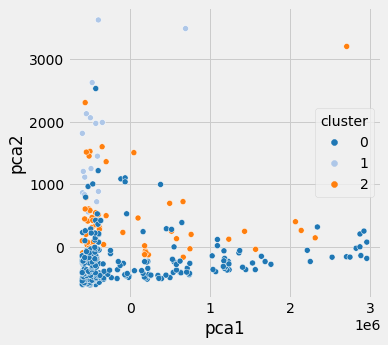

In [25]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df, palette='tab20')
plt.show()

The clusters don't look spheric and they are overlapping, caused by pretty large variances. Perhaps with our data a density based clustering model should be prefered over k-Means.

Variances among features (PCA components)
-----

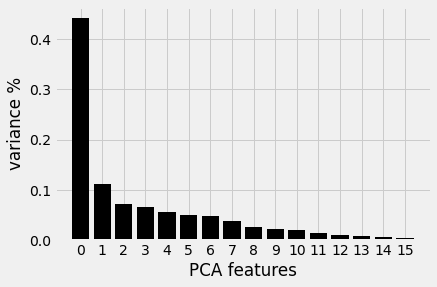

In [26]:
# Standardising and plotting the variances of the features
X_std = StandardScaler().fit_transform(df_poicount.iloc[:, 3:])
pca = PCA(n_components=16)

principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


PCA_components = pd.DataFrame(principalComponents)

It's too simplified, if most of the clustering is based on just one dimension.

Text(0, 0.5, 'PCA 1')

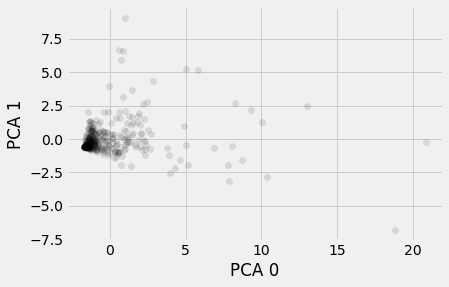

In [28]:
# Plotting the most influencial two features
plt.scatter(PCA_components[0], PCA_components[1], alpha= 0.1, color='black')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')